In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np
from functools import partial

In [2]:
R = 1.0
F0 = 1.0

In [3]:
# class NNApproximator(nn.Module):
#     def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

#         super().__init__()

#         self.layer_in = nn.Linear(1, dim_hidden)
#         self.layer_out = nn.Linear(dim_hidden, 1)

#         num_middle = num_hidden - 1
#         self.middle_layers = nn.ModuleList(
#             [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
#         )
#         self.act = act

#     def forward(self, x):
#         out = self.act(self.layer_in(x))
#         for layer in self.middle_layers:
#             out = self.act(layer(out))
#         return self.layer_out(out)

In [ ]:
#M1
class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.f_layer_in = nn.Linear(1, dim_hidden)
        self.f_layer_out = nn.Linear(dim_hidden, 1)

        f_num_middle = num_hidden - 1
        self.f_middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(f_num_middle)]
        )
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        df_out = self.layer_out(out)
        # df_out = torch.cat((df_out, x), 0)
        f_out = self.act(self.f_layer_in(df_out))
        for layer in self.f_middle_layers:
            f_out = self.act(layer(f_out))
        f_out = self.f_layer_out(f_out)
        return df_out, f_out


In [ ]:
#M3
class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.f_layer_in = nn.Linear(2, dim_hidden)
        self.f_layer_out = nn.Linear(dim_hidden, 1)

        f_num_middle = num_hidden - 1
        self.f_middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(f_num_middle)]
        )
        self.act = act

    def forward(self, x):
        h = 0.5
        f_out = torch.ones(x.shape[0])
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        df_out = self.layer_out(out)
        f_out[0]= F0 + h*df_out[0]
        # print(f_out[1:].shape, f_out[0:-1].shape,  df_out[1:].shape)
        f_out[1:] = f_out[0:-1] +  h*df_out[1:].reshape(-1)
        return df_out, f_out


In [29]:
a = torch.tensor([F0])
b = torch.full(x.shape, 3.141592)

tensor([1.])

In [59]:
#M2
class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.f_layer_in = nn.Linear(3, dim_hidden)
        self.f_layer_out = nn.Linear(dim_hidden, 1)

        f_num_middle = num_hidden - 1
        self.f_middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(f_num_middle)]
        )
        self.act = act

    def forward(self, x):
        x0 = torch.full(x.shape, F0, requires_grad= True)
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        df_out = self.layer_out(out)
        # print(df_out, df_out.shape)
        if x.shape[0]>1:
          df_out = torch.cat((df_out, x, x0), 1)
        else: df_out = torch.cat((df_out, x, x0), 0).reshape(1,3)
        # print(df_out, df_out.shape)
        # print("f")
        f_out = self.act(self.f_layer_in(df_out))
        for layer in self.f_middle_layers:
            f_out = self.act(layer(f_out))
        f_out = self.f_layer_out(f_out)
        return df_out, f_out


In [60]:
#M2
run_model(lr=0.1, m_epochs=20_000)

RuntimeError: ignored

In [57]:
 def f(nn: NNApproximator, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)


def df(nn: NNApproximator, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = f(nn, x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value

de_losses = []
ic_losses = [] 
# def compute_loss(
#     nn: NNApproximator, x: torch.Tensor = None, verbose: bool = False
# ) -> torch.float:
#     # interior_loss = df(nn, x) - R * x * (1 - x)
#     interior_loss = f(nn, x)[0] - R * x * (1 - x)
#     ic = torch.Tensor([0.0])
#     ic.requires_grad = True
#     ic_weight = 0.1
#     # ic_loss = f(nn, ic) - F0
#     ic_loss = f(nn, ic)[1] - F0  
#     de_loss = interior_loss.pow(2).mean() 
#     ic_loss = ic_weight*(ic_loss ** 2)
#     final_loss = de_loss + ic_loss
#     de_losses.append(de_loss)
#     ic_losses.append(ic_loss)
#     return final_loss

def compute_loss(
    nn: NNApproximator, x: torch.Tensor = None, verbose: bool = False
) -> torch.float:
    # interior_loss = df(nn, x) - R * x * (1 - x)
    interior_loss = f(nn, x)[0] - R * x * (1 - x)
    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    boundary_weight = 0.1
    # boundary_loss = f(nn, boundary) - F0
    boundary_loss = f(nn, boundary)[1] - F0 
    # print(interior_loss.pow(2).mean(), boundary_weight*(boundary_loss ** 2))
    final_loss = interior_loss.pow(2).mean() + boundary_weight*(boundary_loss ** 2)
    return final_loss

# def compute_loss(
#     nn: NNApproximator, x: torch.Tensor = None, verbose: bool = False
# ) -> torch.float:
#     # interior_loss = df(nn, x) - R * x * (1 - x)
#     interior_loss = f(nn, x)[0] - R * x * (1 - x)
#     final_loss = interior_loss.pow(2).mean()
#     return final_loss

def train_model(
    nn: NNApproximator,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
) -> NNApproximator:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:

            loss: torch.Tensor = loss_fn(nn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return nn, np.array(loss_evolution)


def check_gradient(nn: NNApproximator, x: torch.Tensor = None) -> bool:

    eps = 1e-4
    dfdx_fd = (f(nn, x + eps) - f(nn, x - eps)) / (2 * eps)
    dfdx_sample = df(nn, x, order=1)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)


In [58]:
#M2
run_model(lr=0.1, m_epochs=3_000)

RuntimeError: ignored

Epoch: 0 - Loss: 0.022414
Epoch: 1000 - Loss: 0.008042
Epoch: 2000 - Loss: 0.007980
Epoch: 3000 - Loss: 0.007873
Epoch: 4000 - Loss: 0.007610
Epoch: 5000 - Loss: 0.006641
Epoch: 6000 - Loss: 0.001472
Epoch: 7000 - Loss: 0.000120
Epoch: 8000 - Loss: 0.000108
Epoch: 9000 - Loss: 0.000162
Epoch: 10000 - Loss: 0.000104
Epoch: 11000 - Loss: 0.000081
Epoch: 12000 - Loss: 0.000062
Epoch: 13000 - Loss: 0.000048
Epoch: 14000 - Loss: 0.000037
Epoch: 15000 - Loss: 0.000028
Epoch: 16000 - Loss: 0.000022
Epoch: 17000 - Loss: 0.000017
Epoch: 18000 - Loss: 0.000014
Epoch: 19000 - Loss: 0.000011


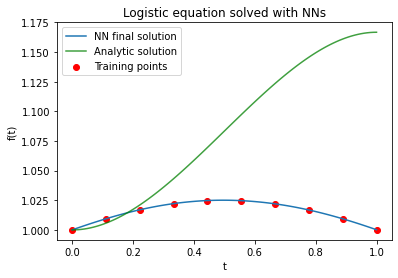

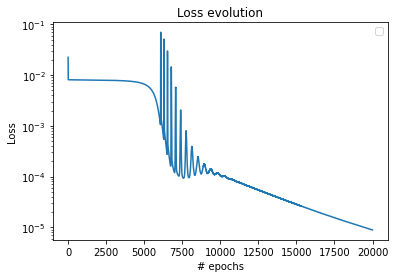

In [ ]:

#M3
run_model(lr=0.1, m_epochs=20_000)

Epoch: 0 - Loss: 0.020791
Epoch: 1000 - Loss: 0.008016
Epoch: 2000 - Loss: 0.007872
Epoch: 3000 - Loss: 0.007640
Epoch: 4000 - Loss: 0.006994
Epoch: 5000 - Loss: 0.003349
Epoch: 6000 - Loss: 0.004283
Epoch: 7000 - Loss: 0.000108
Epoch: 8000 - Loss: 0.000059
Epoch: 9000 - Loss: 0.000062
Epoch: 10000 - Loss: 0.000042
Epoch: 11000 - Loss: 0.000031
Epoch: 12000 - Loss: 0.000025
Epoch: 13000 - Loss: 0.000022
Epoch: 14000 - Loss: 0.000019
Epoch: 15000 - Loss: 0.000018
Epoch: 16000 - Loss: 0.000016
Epoch: 17000 - Loss: 0.000015
Epoch: 18000 - Loss: 0.000014
Epoch: 19000 - Loss: 0.000013


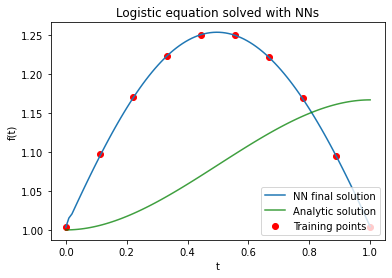

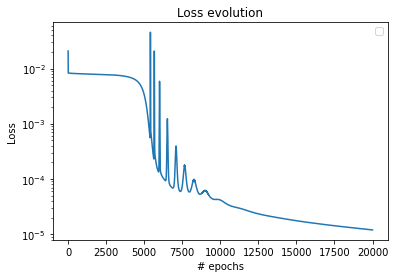

In [ ]:
#M3
run_model(lr=0.1, m_epochs=20_000)

Epoch: 0 - Loss: 0.107869
Epoch: 1000 - Loss: 0.007510
Epoch: 2000 - Loss: 0.004935
Epoch: 3000 - Loss: 0.000144
Epoch: 4000 - Loss: 0.000073
Epoch: 5000 - Loss: 0.000066
Epoch: 6000 - Loss: 0.000079
Epoch: 7000 - Loss: 0.000056
Epoch: 8000 - Loss: 0.000047
Epoch: 9000 - Loss: 0.000040
Epoch: 10000 - Loss: 0.000035
Epoch: 11000 - Loss: 0.000031
Epoch: 12000 - Loss: 0.000028
Epoch: 13000 - Loss: 0.000026
Epoch: 14000 - Loss: 0.000024
Epoch: 15000 - Loss: 0.000023
Epoch: 16000 - Loss: 0.000021
Epoch: 17000 - Loss: 0.000020
Epoch: 18000 - Loss: 0.000019
Epoch: 19000 - Loss: 0.000019


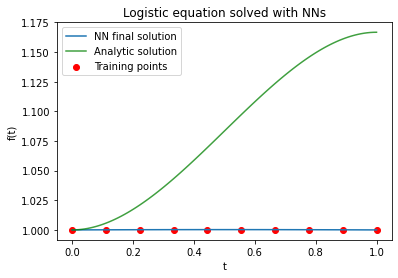

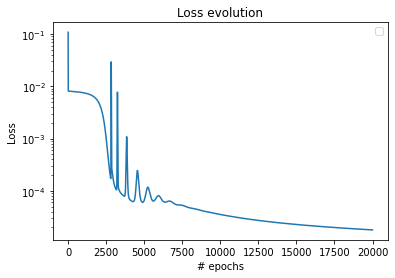

In [ ]:
#M3
run_model(lr=0.1, m_epochs=20_000)

In [50]:
def run_model(lr=0.1, m_epochs=20_000):
    domain = [0.0, 1.0]
    x = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True)
    x = x.reshape(x.shape[0], 1)

    nn_approximator = NNApproximator(4, 10)
    # assert check_gradient(nn_approximator, x)

    # f_initial = f(nn_approximator, x)
    # ax.plot(x.detach().numpy(), f_initial.detach().numpy(), label="Initial NN solution")

    # train the PINN
    loss_fn = partial(compute_loss, x=x, verbose=True)
    nn_approximator_trained, loss_evolution = train_model(
        nn_approximator, loss_fn=loss_fn, learning_rate=lr, max_epochs=m_epochs
    )

    x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

    # numeric solution
    def logistic_eq_fn(x, y):
        return R * x * (1 - x)

    numeric_solution = solve_ivp(
        logistic_eq_fn, domain, [F0], t_eval=x_eval.squeeze().detach().numpy()
    )

    # plotting
    fig, ax = plt.subplots()

    f_final_training = f(nn_approximator_trained, x)[1]
    f_final = f(nn_approximator_trained, x_eval)[1]

    ax.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points", color="red")
    ax.plot(x_eval.detach().numpy(), f_final.detach().numpy(), label="NN final solution")
    ax.plot(
        x_eval.detach().numpy(),
        numeric_solution.y.T,
        label=f"Analytic solution",
        color="green",
        alpha=0.75,
    )
    ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
    ax.legend()

    fig, ax = plt.subplots()
    # print(loss_evolution.shape)
    ax.semilogy(loss_evolution.reshape(-1,1))
    ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
    ax.legend()

    plt.show()
    plt.plot(de_losses, ic_losses)
    plt.show()

Epoch: 0 - Loss: 0.251749
Epoch: 1000 - Loss: 0.120773
Epoch: 2000 - Loss: 0.120621
Epoch: 3000 - Loss: 0.120330
Epoch: 4000 - Loss: 0.119551
Epoch: 5000 - Loss: 0.117487
Epoch: 6000 - Loss: 0.116866
Epoch: 7000 - Loss: 0.116863
Epoch: 8000 - Loss: 0.116862
Epoch: 9000 - Loss: 0.116861
Epoch: 10000 - Loss: 0.116861
Epoch: 11000 - Loss: 0.116860
Epoch: 12000 - Loss: 0.116860
Epoch: 13000 - Loss: 0.116860
Epoch: 14000 - Loss: 0.116859
Epoch: 15000 - Loss: 0.116859
Epoch: 16000 - Loss: 0.116859
Epoch: 17000 - Loss: 0.116858
Epoch: 18000 - Loss: 0.116858
Epoch: 19000 - Loss: 0.116858


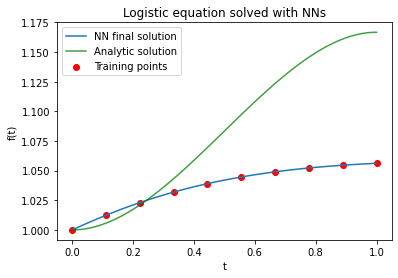

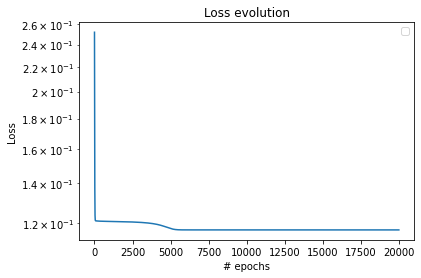

In [ ]:
#M2
run_model(lr=0.1, m_epochs=20_000)